In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from matplotlib.gridspec import GridSpec
from sklearn.datasets import load_iris

In [35]:
# улучшаем читаемость данных
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
# делаем единый стиль графиков
sns.set(style='whitegrid', context='notebook')

In [3]:
# 01. Загрузка данных и быстрый взгляд
# 02. Приведение типов, базовая чистка
# 03. Анализ пропусков, заполнение
# 04. Создание вспомогательных фичей
# 05. Базовые описательные статистики (Stage 2)
# 06. Выбросы: диагностика и фильтрация
# 07. Корреляции и scatterplots (Stage 3, уже на очищенных данных)
# 08. Локальный анализ по пригородам/регионам (Stage 4)
# 09. Финальные выводы и гипотезы (Stage 5, текстом)
# 10. (Опционально) Приложение: проверка устойчивости результатов (до/после чистки)

In [4]:
# 01. Загрузка данных и быстрый взгляд

In [5]:
# df_houses = pd.read_csv('/Users/vladislavlipkin/Downloads/melb_data.csv') # MAC OS
df_houses = pd.read_csv(r'C:\Users\Incognitus\Downloads\melb_data.csv') # WINDOWS

In [6]:
# df_houses.head(10)
# df_houses.shape
df_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

In [7]:
# просмотр таблицы , топ 5 дорогих объектов
df_houses.sort_values(by='Price', ascending=False).head(5)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
12094,Mulgrave,35 Bevis St,3,h,"9,000,000.00",PI,Hall,29/07/2017,18.80,"3,170.00",...,1.00,1.00,744.00,117.00,"1,960.00",Monash,-37.93,145.16,South-Eastern Metropolitan,"7,113.00"
7692,Canterbury,49 Mangarra Rd,5,h,"8,000,000.00",VB,Sotheby's,13/05/2017,9.00,"3,126.00",...,5.00,4.00,"2,079.00",464.30,"1,880.00",Boroondara,-37.82,145.07,Southern Metropolitan,"3,265.00"
9575,Hawthorn,49 Lisson Gr,4,h,"7,650,000.00",S,Abercromby's,17/06/2017,5.30,"3,122.00",...,2.00,4.00,"1,690.00",284.00,"1,863.00",Boroondara,-37.83,145.03,Southern Metropolitan,"11,308.00"
3616,Kew,15 Barry St,6,h,"6,500,000.00",S,Jellis,13/08/2016,5.60,"3,101.00",...,6.00,3.00,"1,334.00",365.00,"1,890.00",Boroondara,-37.80,145.03,Southern Metropolitan,"10,331.00"
12557,Middle Park,136 Page St,5,h,"6,400,000.00",S,Marshall,9/09/2017,3.00,"3,206.00",...,2.00,1.00,553.00,308.00,"1,920.00",NaN,-37.85,144.96,Southern Metropolitan,"2,019.00"


In [8]:
# 02. Приведение типов, базовая чистка

In [9]:
# преобразовываем дату
df_houses['Date'] = pd.to_datetime(df_houses['Date'], format='%d/%m/%Y', errors='coerce')

# Строковые категории — в category (экономит память, удобнее группировать)
cat_cols = ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname', 'Postcode']
for c in cat_cols:
    if c in df_houses.columns:
        df_houses[c] = df_houses[c].astype('category')

# Создадим копию сырых данных
df_raw = df_houses.copy()

In [11]:
# 03. Анализ пропусков, заполнение

In [13]:
# найти пропущенные строки
df_houses.isnull().sum().sort_values(ascending=False)

CouncilArea      1369
Suburb              0
Bathroom            0
Regionname          0
Longtitude          0
Lattitude           0
YearBuilt           0
BuildingArea        0
Landsize            0
Car                 0
Bedroom2            0
Address             0
Postcode            0
Distance            0
Date                0
SellerG             0
Method              0
Price               0
Type                0
Rooms               0
Propertycount       0
dtype: int64

In [12]:
#  заполнение медианой сначала в Suburb, после в оставшихся NaN общей медианой по столбцу
for col in ['BuildingArea', 'Landsize', 'YearBuilt', 'Car']:
    if col in df_houses.columns:
        # заполнение пустых ячеек по Suburb
        df_houses[col] = df_houses[col].fillna(df_houses.groupby('Suburb')[col].transform('median'))
        # страховка , заполнение по всему столбцу без группировки
        df_houses[col] = df_houses[col].fillna(df_houses[col].median())

C:\Users\Incognitus\AppData\Local\Temp\ipykernel_2864\4030824298.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_houses[col] = df_houses[col].fillna(df_houses.groupby('Suburb')[col].transform('median'))


In [14]:
# 04. Создание вспомогательных фичей

In [15]:
# сделать столбец стоимость (Price) более читаемым
df_houses['price_mln'] = df_houses['Price'] / 1_000_000
# бины по расстоянию для BOXPLOT
df_houses['Distance_bin'] = pd.qcut(df_houses['Distance'], q=5, duplicates='drop')

In [17]:
# 05. Базовые описательные статистики (Stage 2)
# Средняя/медианная цена по регионам/пригородам/типам и т.д.

In [18]:
# 05.1
# 05.1 — медиана по Regionname
price_region = (
    df_houses.groupby('Regionname')['Price']
    .median()
    .sort_values(ascending=False)
    .rename('median_price')
    .reset_index()
)

price_region['median_price_mln'] = price_region['median_price'] / 1_000_000
price_region

C:\Users\Incognitus\AppData\Local\Temp\ipykernel_2864\1853917866.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_houses.groupby('Regionname')['Price']


,Regionname,median_price,median_price_mln
0,Southern Metropolitan,"1,250,000.00",1.25
1,Eastern Metropolitan,"1,010,000.00",1.01
2,South-Eastern Metropolitan,"850,000.00",0.85
3,Northern Metropolitan,"806,250.00",0.81
4,Western Metropolitan,"793,000.00",0.79
5,Eastern Victoria,"670,000.00",0.67
6,Northern Victoria,"540,000.00",0.54
7,Western Victoria,"400,000.00",0.40


In [20]:
# 05.2 — топ-10 пригородов по медианной цене
price_suburb = (
    df_houses.groupby('Suburb')['Price']
    .median()
    .sort_values(ascending=False)
    .rename('median_price')
    .reset_index()
)
top10_suburbs = price_suburb.head(10)
top10_suburbs

C:\Users\Incognitus\AppData\Local\Temp\ipykernel_2864\4138098678.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_houses.groupby('Suburb')['Price']


,Suburb,median_price
0,Kooyong,"2,185,000.00"
1,Eaglemont,"1,901,000.00"
2,Albert Park,"1,900,000.00"
3,Canterbury,"1,890,000.00"
4,Middle Park,"1,880,000.00"
5,Balwyn,"1,850,000.00"
6,Brighton,"1,773,500.00"
7,Kew East,"1,750,000.00"
8,Ivanhoe East,"1,740,000.00"
9,Balwyn North,"1,739,000.00"


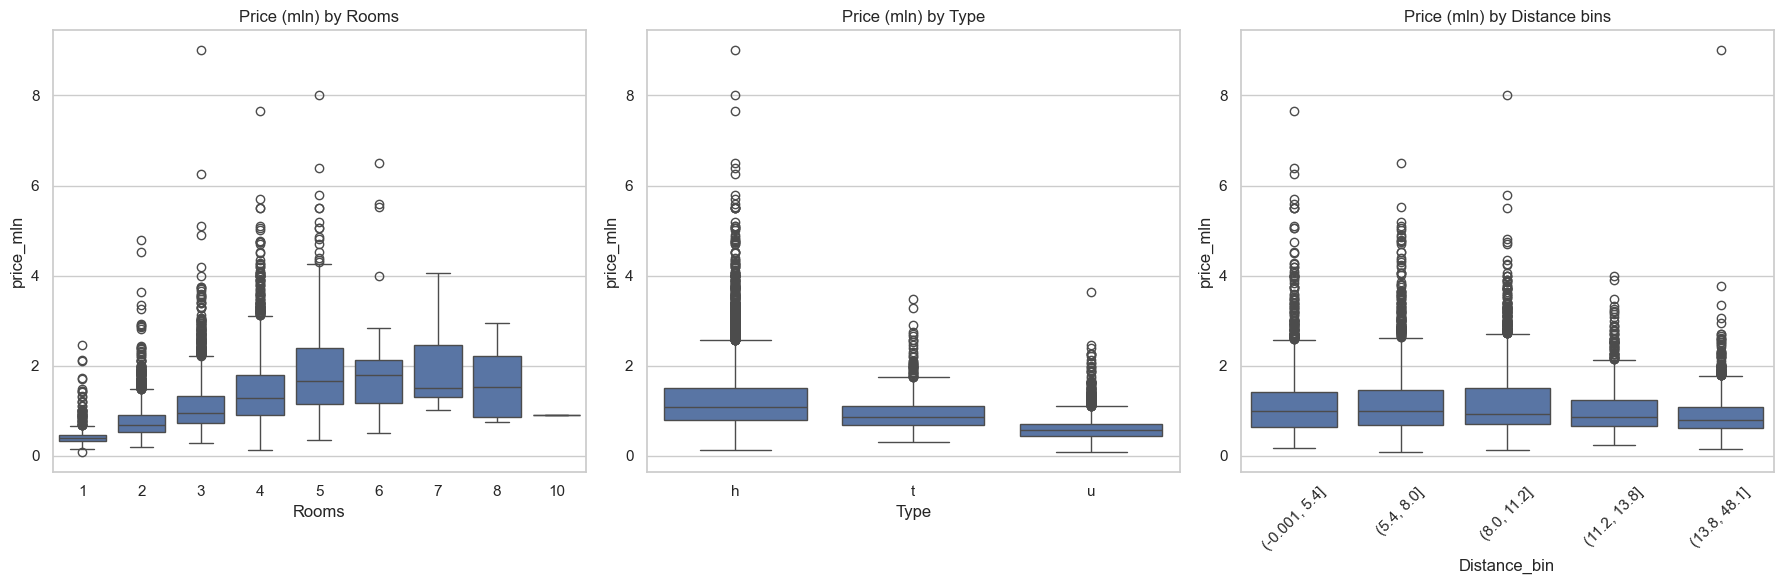

In [23]:
# 05.3. Визуализации распределений/boxplot

# Создаём фигуру с тремя подграфиками в одном ряду
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 05.3a — Boxplot: Price vs Rooms
sns.boxplot(data=df_houses, x='Rooms', y='price_mln', ax=axes[0])
axes[0].set_title('Price (mln) by Rooms')

# 05.3b — Boxplot: Price vs Type
sns.boxplot(data=df_houses, x='Type', y='price_mln', ax=axes[1])
axes[1].set_title('Price (mln) by Type')

# 05.3c — Boxplot: Price vs Distance bins
sns.boxplot(data=df_houses, x='Distance_bin', y='price_mln', ax=axes[2])
axes[2].set_title('Price (mln) by Distance bins')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

In [24]:
# 06. Выбросы: диагностика и фильтрация

In [29]:
# 06.1 — функция для подсчёта выбросов
def count_outliers_iqr(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return ((series < low) | (series > high)).sum()

print('Выбросы по полю Rooms')
print(df_houses.groupby('Rooms')['Price'].apply(count_outliers_iqr))
print('')
print('Выбросы по полю Type')
print(df_houses.groupby('Type')['Price'].apply(count_outliers_iqr))

Выбросы по полю Rooms
Rooms
1      52
2     149
3     173
4      95
5      15
6       4
7       0
8       0
10      0
Name: Price, dtype: int64

Выбросы по полю Type
Type
h    430
t     43
u    127
Name: Price, dtype: int64


C:\Users\Incognitus\AppData\Local\Temp\ipykernel_2864\1105255076.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_houses.groupby('Type')['Price'].apply(count_outliers_iqr))


In [ ]:
# 06.2 — фильтруем “физически невозможные” и явные ошибки:


In [33]:
# 06.2 — фильтруем “физически невозможные” и явные ошибки:
# BuildingArea > 0, < 1000
# Landsize > 0, BuildingArea < Landsize
# Rooms > 0
mask_valid = (
    (df_houses['BuildingArea'].gt(0) & df_houses['BuildingArea'].lt(1000)) &
    (df_houses['Landsize'].gt(0)) &
    (df_houses['BuildingArea'] < df_houses['Landsize']) &
    (df_houses['Rooms'] > 0)
)

df_clean = df_houses[mask_valid].copy()
print(f'отфильтрованный DF {df_clean.shape}') 
print(f'изначальный DF {df_houses.shape}')

отфильтрованный DF (11061, 23)
изначальный DF (13580, 23)


In [36]:
# 07. Корреляции и scatterplots (Stage 3, на очищенных данных)

In [37]:
# IMHERE!